### Imports

In [1]:
import torch
import abmax.structs as abx_struct
import abmax.functions as abx_func
import jax.numpy as jnp
import jax.random as random
import jax
import numpy as np
import matplotlib.pyplot as plt
from flax import struct
from abmax.structs import *
from benchmarks import (SIX_HUMP_WIDE, SIX_HUMP_CLASSIC, evaluate_objective, get_default_bounds)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Defining the agents

In [3]:
@struct.dataclass
class Forager(abx_struct.Agent):
    @staticmethod
    def create_agent(type,params: abx_struct.Params | None,id: jnp.int32,active_state: bool,key: jax.random.PRNGKey):
        """
        Creating a single agent
        """

        # Hyperparamaters
        default_objective = SIX_HUMP_WIDE
        defaults = {'objective_id'  : default_objective}

        # Allows for extrenal overides, but enables the use of defined hyperparamaters if none are inputed
        incoming = {} if (params is None or not hasattr(params, "content")) else params.content
        hyperparamaters = {**defaults, **incoming}   # set of final Hyperparmaters for the agent

        #   
        objective_id = int(hyperparamaters.get("objective_id", default_objective))

        #   
        if "bounds" in hyperparamaters:
            bounds = hyperparamaters["bounds"]
        else:
            bounds = get_default_bounds(objective_id)
            hyperparamaters["bounds"] = bounds 

        # Paramaters object and agent carries, agent_params is a dictionary
        agent_params = abx_struct.Params(content=hyperparamaters)

        # Random uniform initialization  
        # Gets number of dimensions in the search space
        d = bounds.shape[0] 
        # Each agent gets different key
        key, k0 = random.split(key)
        lo, hi = bounds[:, 0], bounds[:, 1]
        pos = random.uniform(k0, (d,), minval=lo, maxval=hi)

        # Evaluating the agents starting position when initialized
        fit = evaluate_objective(pos, objective_id).astype(jnp.float32)

        # State 
        state_content = {
            'pos': pos,                                  # current point (real space)
            'fit': fit,                                  # fitnnes
            'best_pos': pos,                             # personal best position
            'best_fit': fit,                             # personal best fitnnes
            'evals': jnp.asarray(1, jnp.int32),          # number of evaluations of the current position the agent has done
        }
        # States which agent carries
        agent_state = abx_struct.State(content=state_content)   
        
        return Forager(params=agent_params,id=id,state=agent_state,agent_type=type,key=key,policy=None,age=jnp.asarray(0.0, jnp.float32),active_state=active_state)
    
    @staticmethod
    def create_agent_at_pos(type,params: abx_struct.Params | None,id: jnp.int32, active_state: bool,key: jax.random.PRNGKey, pos: jnp.ndarray):
        """
        Creating a single agent at a given position
        """

        # Hyperparamaters
        default_objective = SIX_HUMP_WIDE
        defaults = {'objective_id'  : default_objective}

        # Allows for extrenal overides, but enables the use of defined hyperparamaters if none are inputed
        incoming = {} if (params is None or not hasattr(params, "content")) else params.content
        hyperparamaters = {**defaults, **incoming}   # set of final Hyperparmaters for the agent

        #
        objective_id = int(hyperparamaters.get("objective_id", default_objective))

        #
        if "bounds" in hyperparamaters:
            bounds = hyperparamaters["bounds"]
        else:
            bounds = get_default_bounds(objective_id)
            hyperparamaters["bounds"] = bounds 

        # Paramaters object and agent carries, agent_params is a dictionary
        agent_params = abx_struct.Params(content=hyperparamaters)

        # Evaluating the agents starting position when initialized
        fit = evaluate_objective(pos, objective_id).astype(jnp.float32)

        # State 
        state_content = {
            'pos': pos,                                  # current point (real space)
            'fit': fit,                                  # fitnnes
            'best_pos': pos,                             # personal best position
            'best_fit': fit,                             # personal best fitnnes
            'evals': jnp.asarray(1, jnp.int32),          # number of evaluations of the current position the agent has done
        }
        # States which agent carries
        agent_state = abx_struct.State(content=state_content)  
        return Forager(params=agent_params,id=id,state=agent_state,agent_type=type,key=key,policy=None,age=jnp.asarray(0.0, jnp.float32),active_state=active_state)
    
    @staticmethod
    def sort_agents_by_fitness(agents):
        """
        Sort agents in ascending order of fitness.
        (Best agent first, worst agent last.)

        Args:
            agents: batched Agent/Forager pytree (e.g. result of vmap).

        Returns:
            agents_sorted: same structure, sorted by fitness.
            sorted_idx:   indices such that fitness[sorted_idx] is ascending.
        """
        # Getting fitness values
        fit_all = agents.state.content["fit"]
        # Flattening fitness to 1D array
        quantity = jnp.reshape(fit_all, (-1,))
        # Sorting ascending order
        sorted_idx = jnp.argsort(quantity)
        # Generating sorted agents
        agents_sorted = jax.tree_util.tree_map(lambda x: jnp.take(x, sorted_idx, axis=0), agents)

        return agents_sorted, sorted_idx
    #@staticmethod
    #def step_agent(agent, input, step_params):
        #def step_inactive_agent():
            #return agent
        
        #def step_active_agent():
            # Unpacking agent hyperparamaters
            #p = agent.params.content
            #bounds = p['bounds']
            #objective_id = hyperparamaters['objective_id']
            
        

        
        #new_agent = jax.lax.cond(agent.active_state, lambda _: step_active_agent(), lambda _: step_inactive_agent(), None)
        #return new_agent
    
    
    #@staticmethod
    #def remove_agent(agents, idx, remove_params):
        #agent_to_remove = jax.tree_util.tree_map(lambda x:x[idx], agents)
        #new_state_content = {'draw': 0}
        #new_state = abx_struct.State(content = new_state_content)
        #return agent_to_remove.replace(state = new_state, active_state = False, age = 0.0)
    
    #@staticmethod
    #def add_agent(agents, idx, add_params):
        #agent_to_add = jax.tree_util.tree_map(lambda x:x[idx], agents)
        #key, subkey = random.split(agent_to_add.key)
        #draw = jax.random.randint(subkey, (1,), 1, 7)
        #state_content = {'draw': draw}
        #new_state = abx_struct.State(content=state_content)

        #return agent_to_add.replace(state = new_state, key = key, active_state = True, age = 0.0)


## Initialization and random generation of agents

In [4]:
# MAIN
# Initialization of a population of agents
# Number of agents in the initial population (this is N)
num_agents = 10
agent_type = jnp.int16(0)

# Choosing a benchmark objective
objective_id = SIX_HUMP_CLASSIC   # or SIX_HUMP_CLASSIC

bounds = get_default_bounds(objective_id)
agent_hyper = {"bounds": bounds, "objective_id": objective_id}
agent_params = abx_struct.Params(content=agent_hyper)


# PRNG key for JAX - all randomness in JAX is explicitly managed via PRNG keys
key = random.PRNGKey(2)

# Creating ids and active flags for agents
ids = jnp.arange(num_agents, dtype=jnp.int32)
active_states = jnp.ones(num_agents, dtype=bool)

# Split key into one subkey per agent
key, key_agents = random.split(key)
subkeys = random.split(key_agents, num_agents)  # shape (num_agents,)

# Vectorized creation of agents:
# Creating agents
agents = jax.vmap(Forager.create_agent,in_axes=(None, None, 0, 0, 0),)(agent_type, agent_params, ids, active_states, subkeys)
# Extract positions and fitnesses from the batched agents
pos = agents.state.content["pos"]  # shape (num_agents, D)
fit = agents.state.content["fit"]  # shape (num_agents,)

print("Positions shape:", pos.shape)
print("Fitness shape:", fit.shape)

print("All ten positions:\n", pos[::])
print("All ten fitnesses:\n", fit[::])

# Check bounds
bounds = agent_hyper["bounds"]
lo, hi = bounds[:, 0], bounds[:, 1]

print("Min pos per dim:", pos.min(axis=0))
print("Max pos per dim:", pos.max(axis=0))



Positions shape: (10, 2)
Fitness shape: (10,)
All ten positions:
 [[ 1.4491911  -0.6394732 ]
 [ 1.1290922   0.23849368]
 [-1.4513755   0.3006053 ]
 [ 0.898767   -0.87083864]
 [ 0.20556402 -0.6560216 ]
 [ 0.13951588  0.9884715 ]
 [-1.9146376   0.19777322]
 [-1.4410925   0.39427328]
 [ 0.4255724  -0.82652116]
 [ 1.7257547  -0.13208747]]
All ten fitnesses:
 [ 0.3323959   2.431743    1.4582558   0.5208676  -0.9501563   0.12537882
  2.3347363   1.1422005  -0.56004304  1.7951951 ]
Min pos per dim: [-1.9146376  -0.87083864]
Max pos per dim: [1.7257547 0.9884715]


## Visualization of randomly generated agents

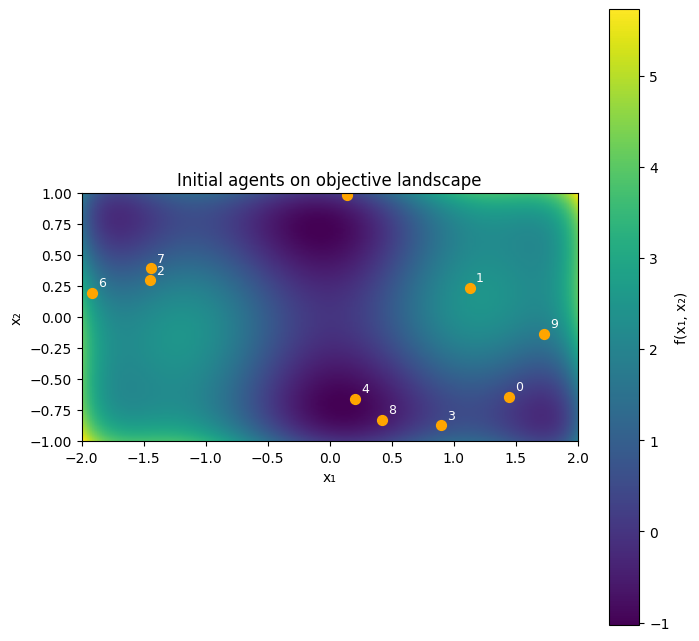

In [5]:
# Getting bounds from the objective id
bounds = get_default_bounds(objective_id)  # shape (2, 2)

# Making grid
x = jnp.linspace(bounds[0, 0], bounds[0, 1], 200)
y = jnp.linspace(bounds[1, 0], bounds[1, 1], 200)
xg, yg = jnp.meshgrid(x, y)

# Evaluationg objectives on the grid to produce a heat map
Z = evaluate_objective(jnp.array([xg, yg]), objective_id)

# Getting agent positions for plotting
x_agents = np.array(pos[:, 0])
y_agents = np.array(pos[:, 1])
ids_np   = np.array(ids)

# Plotting heatmap
plt.figure(figsize=(8, 8))
heat_map = plt.imshow(Z, extent=[float(bounds[0, 0]), float(bounds[0, 1]),float(bounds[1, 0]), float(bounds[1, 1])], origin="lower",aspect="auto")
plt.colorbar(heat_map, label="f(x₁, x₂)")

# Plotting agents
plt.scatter(x_agents, y_agents, s=50, color="orange")

for i in range(len(x_agents)):
    plt.text(float(x_agents[i]) + 0.05, float(y_agents[i]) + 0.05, str(int(ids_np[i])), fontsize=9, color="white")

plt.xlim(bounds[0, 0], bounds[0, 1])
plt.ylim(bounds[1, 0], bounds[1, 1])
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Initial agents on objective landscape")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()



## Generating quassi opposite agents

In [6]:
# Bounds and center
center = (lo + hi) / 2.0  

# Finding oposite position for each agent
pos_op = lo + hi - pos  

# Generating quasi opposite position - random uniform sampling between center and pos_op
key, key_q = random.split(key)
u = random.uniform(key_q, shape=pos.shape)  
q_low  = jnp.minimum(center, pos_op)       
q_high = jnp.maximum(center, pos_op)
pos_qop = q_low + u * (q_high - q_low)

num_agents = pos.shape[0]   
agent_type = jnp.int16(0)

# IDs for quasi agents
ids_orig = ids                                 
ids_qop  = ids + num_agents

active_qop = jnp.ones(num_agents, dtype=bool)

# Random keys for quasi agents
key, key_q_agents = random.split(key)
subkeys_q = random.split(key_q_agents, num_agents)

# Creating quasi agents
agents_qop = jax.vmap(Forager.create_agent_at_pos, in_axes=(None, None, 0, 0, 0, 0),)(agent_type, agent_params, ids_qop, active_qop, subkeys_q, pos_qop)

pos_qop_eval = agents_qop.state.content["pos"]
fit_qop      = agents_qop.state.content["fit"]

print("Original 2:", pos[2])
print("Quasi    2:", pos_qop[2])

print("QOP fitness shape:", fit.shape)
print("All QOP fitnesses:\n", fit[::])

print("QOP positions shape:", pos_qop.shape)
print("All QOP positions:\n", pos_qop[::])




Original 2: [-1.4513755  0.3006053]
Quasi    2: [ 1.3903127  -0.22731872]
QOP fitness shape: (10,)
All QOP fitnesses:
 [ 0.3323959   2.431743    1.4582558   0.5208676  -0.9501563   0.12537882
  2.3347363   1.1422005  -0.56004304  1.7951951 ]
QOP positions shape: (10, 2)
All QOP positions:
 [[-0.19606113  0.27138403]
 [-0.5879063  -0.03670046]
 [ 1.3903127  -0.22731872]
 [-0.53059256  0.2997408 ]
 [-0.12069341  0.6021895 ]
 [-0.09116763 -0.820902  ]
 [ 1.9071225  -0.17267917]
 [ 0.00256468 -0.13513109]
 [-0.3706625   0.432744  ]
 [-1.6402612   0.09000289]]


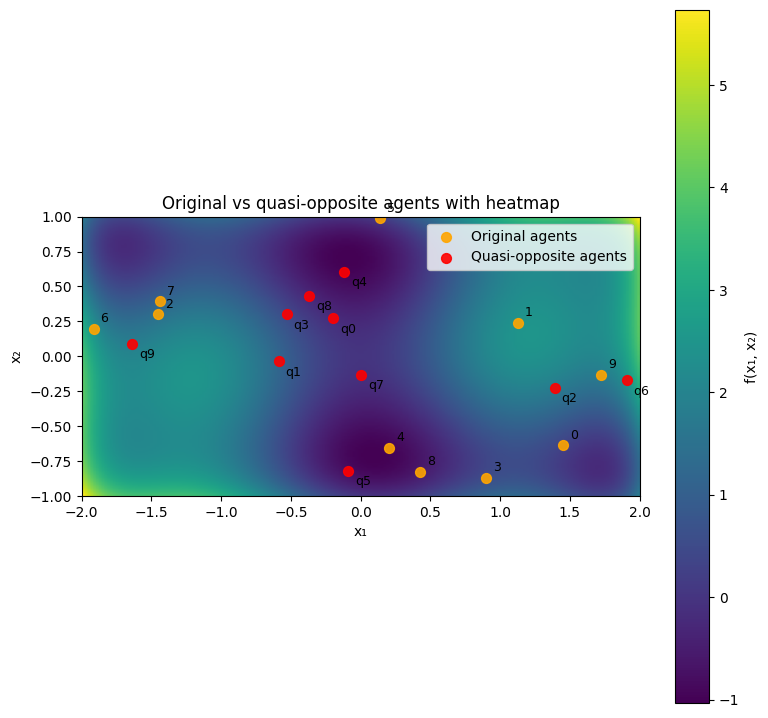

In [7]:


# Getting bounds from the objective id
bounds = get_default_bounds(objective_id)  

x = jnp.linspace(bounds[0, 0], bounds[0, 1], 200)
y = jnp.linspace(bounds[1, 0], bounds[1, 1], 200)
xg, yg = jnp.meshgrid(x, y)

Z = evaluate_objective(jnp.array([xg, yg]), objective_id)
Z = np.array(Z)  # for matplotlib

# Getting agent positions
x_orig = np.array(pos[:, 0])
y_orig = np.array(pos[:, 1])

x_q = np.array(pos_qop[:, 0])
y_q = np.array(pos_qop[:, 1])

ids_np = np.array(ids)

# # Plotting heatmap with original and quasi-opposite agents
plt.figure(figsize=(9, 9))

# Background heatmap
heat_map = plt.imshow(Z, extent=[float(bounds[0, 0]), float(bounds[0, 1]), float(bounds[1, 0]), float(bounds[1, 1])], origin="lower", aspect="auto")
plt.colorbar(heat_map, label="f(x₁, x₂)")

# Original agents in orange
plt.scatter(x_orig, y_orig, s=50, color="orange", label="Original agents", alpha=0.9)

# Quasi-opposite agents in purple
plt.scatter(x_q, y_q, s=50, color="red", label="Quasi-opposite agents", alpha=0.9)

# Label original agents with their id
for i in range(len(x_orig)):
    plt.text(float(x_orig[i]) + 0.05, float(y_orig[i]) + 0.05, str(int(ids_np[i])), fontsize=9, color="black")

# Label quasi agents with "q{id}"
for i in range(len(x_q)):
    plt.text(float(x_q[i]) + 0.05, float(y_q[i]) - 0.10, f"q{int(ids_np[i])}", fontsize=9, color="black")

plt.xlim(bounds[0, 0], bounds[0, 1])
plt.ylim(bounds[1, 0], bounds[1, 1])
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Original vs quasi-opposite agents with heatmap")
plt.grid(False)
plt.legend()
plt.gca().set_aspect("equal", adjustable="box")
plt.show()






## Extracting best N/2 agents from the set of randomly generated agents and quasi generated agents

In [8]:
# Combining original and quasi-opposite agents into a single population
agents_all = jax.tree_util.tree_map(lambda a, b: jnp.concatenate([a, b], axis=0), agents, agents_qop)

print("Combined agents positions shape:", agents_all.state.content["pos"].shape)
print("Combined agents fitness shape:", agents_all.state.content["fit"].shape)

# 0 = original, 1 = quasi
origin_flags_all = jnp.concatenate([jnp.zeros(num_agents, dtype=jnp.int32), jnp.ones(num_agents, dtype=jnp.int32)])

# Sort all 2N agents by fitness (ascending)
agents_sorted, sorted_idx = Forager.sort_agents_by_fitness(agents_all)
origin_sorted = origin_flags_all[sorted_idx]

# Keep only the best half
M = agents_sorted.state.content["fit"].shape[0]   # should be 2N
M_keep = M // 2                                   # N

agents_init = jax.tree_util.tree_map(lambda x: x[:M_keep], agents_sorted)
origin_init = origin_sorted[:M_keep]

# For checks
pos_init = agents_init.state.content["pos"]
fit_init = agents_init.state.content["fit"]
ids_init = agents_init.id

print("Initial population size:", pos_init.shape[0])  # should be N
print("Ids:", ids_init)
print("Origin flags (0=orig, 1=quasi):", origin_init)




Combined agents positions shape: (20, 2)
Combined agents fitness shape: (20,)
Initial population size: 10
Ids: [ 4 14 15  8 18 10 17  5  0 13]
Origin flags (0=orig, 1=quasi): [0 1 1 0 1 1 1 0 0 1]


## Plotting N best agents which will be used in algorithm

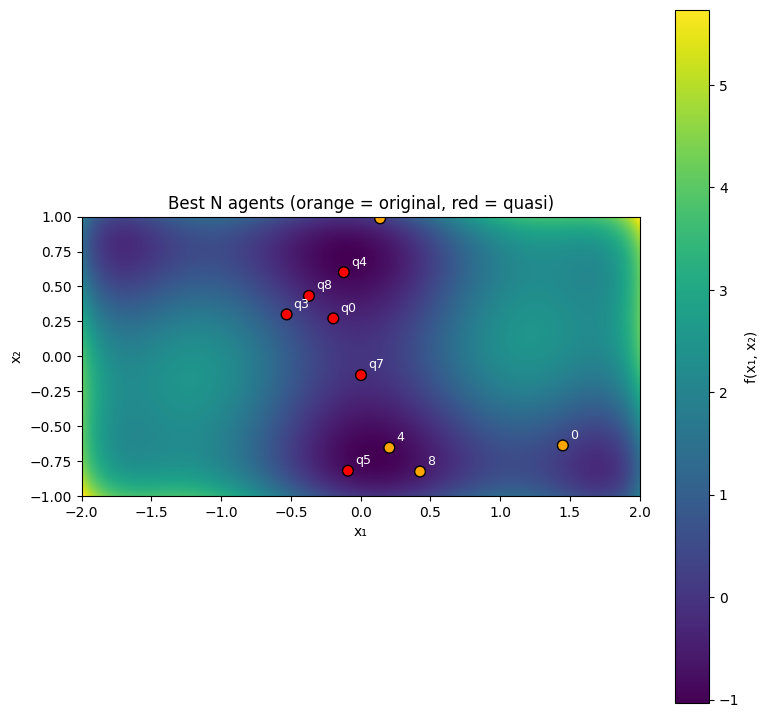

In [9]:
# positions & ids for plotting
pos_init_np    = np.array(pos_init)
x_agents       = pos_init_np[:, 0]
y_agents       = pos_init_np[:, 1]
ids_init_np    = np.array(ids_init)
origin_init_np = np.array(origin_init)

# Plotting
colors = np.where(origin_init_np == 0, "orange", "red")

plt.figure(figsize=(9, 9))
heat_map = plt.imshow(Z, extent=[float(bounds[0, 0]), float(bounds[0, 1]), float(bounds[1, 0]), float(bounds[1, 1])], origin="lower", aspect="auto")
plt.colorbar(heat_map, label="f(x₁, x₂)")
plt.scatter(x_agents, y_agents, s=60, c=colors, edgecolors="black")

for i in range(len(x_agents)):
    if origin_init_np[i] == 0:
        label = str(int(ids_init_np[i]))      # original
    else:
        
        base_id = int(ids_init_np[i] % num_agents)
        label = f"q{base_id}"                 # quasi
    plt.text(float(x_agents[i]) + 0.05, float(y_agents[i]) + 0.05, label, fontsize=9, color="white")

plt.xlim(bounds[0, 0], bounds[0, 1])
plt.ylim(bounds[1, 0], bounds[1, 1])
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Best N agents (orange = original, red = quasi)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()
